In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import scipy.stats as ss
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
df_ori = pd.read_csv('data-ori.csv')
df_ori.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [3]:
df = df_ori.copy()

In [4]:
bsDesc = []

for i in df.columns:
    bsDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = bsDesc,
            columns = [
                'Features',
                'DataType',
                'Null',
                'NullPercentage',
                'Unique',
                'Unique Sample'
            ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,HAEMATOCRIT,float64,0,0.0,326,"[45.8, 49.3]"
1,HAEMOGLOBINS,float64,0,0.0,128,"[14.9, 13.0]"
2,ERYTHROCYTE,float64,0,0.0,433,"[6.39, 3.73]"
3,LEUCOCYTE,float64,0,0.0,276,"[18.9, 14.6]"
4,THROMBOCYTE,int64,0,0.0,554,"[24, 230]"
5,MCH,float64,0,0.0,189,"[24.5, 17.9]"
6,MCHC,float64,0,0.0,105,"[35.0, 34.8]"
7,MCV,float64,0,0.0,406,"[60.6, 104.4]"
8,AGE,int64,0,0.0,95,"[55, 25]"
9,SEX,object,0,0.0,2,"[M, F]"


In [5]:
df.SOURCE.value_counts()

out    2628
in     1784
Name: SOURCE, dtype: int64

In [6]:
df['SEX'] = df['SEX'].replace({'F': 0, 'M': 1})
df['SOURCE'] = df['SOURCE'].replace({'out': 0, 'in': 1})

In [7]:
def cramers(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1) * (r-2)) / (n-1))
    rcorr = r - ((r-1) ** 2)/(n-1)
    kcorr = k - ((k-1) ** 2)/(n-1)
    return np.sqrt(phi2corr/ min((kcorr -1), (rcorr-1)))

In [8]:
y_col = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE' , 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX']
for i in range(len(y_col)):
    cor_res = cramers(df['SOURCE'], df[y_col[i]])
    
    print('{}: {}'.format(y_col[i], round((cor_res * 100), 2)))

HAEMATOCRIT: 38.84
HAEMOGLOBINS: 31.28
ERYTHROCYTE: 40.91
LEUCOCYTE: 33.67
THROMBOCYTE: 47.8
MCH: 19.66
MCHC: 17.44
MCV: 32.42
AGE: 23.42
SEX: 5.13


In [9]:
# THROMBOCYTE: 47.8
# ERYTHROCYTE: 40.91
# HAEMATOCRIT: 38.84
# LEUCOCYTE: 33.67
# MCV: 32.42
# HAEMOGLOBINS: 31.28
# AGE: 23.42
# MCH: 19.66
# MCHC: 17.44
# SEX: 5.13

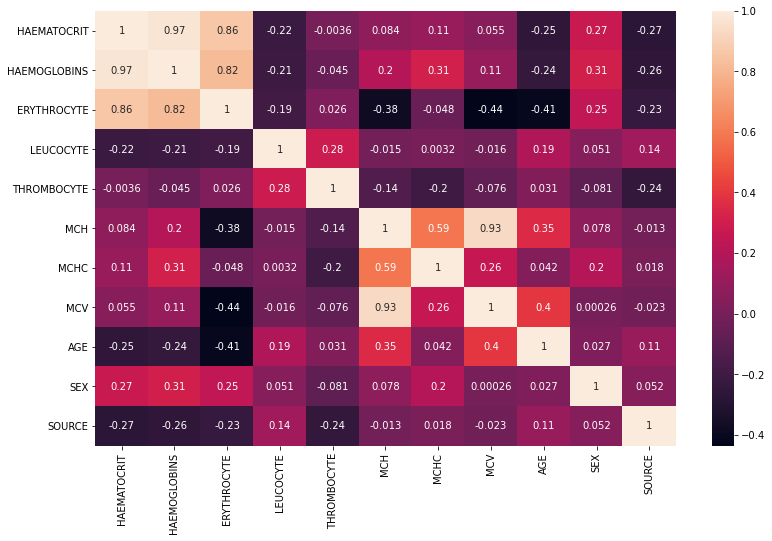

In [10]:
plt.figure(figsize=(13,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [11]:
def Eva_Matrix2(Model, X_train, y_train, X_test, y_test, name):
    y_pred_train = Model.predict(X_train)
    y_pred_test = Model.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_train = recall_score(y_train, y_pred_train)
    rec_test = recall_score(y_test, y_pred_test)
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
        
    data = {
        f"Training {name}": [acc_train, rec_train, prec_train],
        f"Testing {name}": [acc_test, rec_test, prec_test]
    }
    
    df_eva = pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision'])
    return df_eva

### Start Train - Test Base

In [12]:
X = df.drop(columns='SOURCE')
y = df['SOURCE']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [14]:
LR_Base = LogisticRegression().fit(X_train, y_train)

In [15]:
KNN_Base = KNeighborsClassifier().fit(X_train, y_train)

In [16]:
SVM_Base = SVC().fit(X_train, y_train)

In [17]:
DT_Base = DecisionTreeClassifier().fit(X_train, y_train)

In [18]:
RF_Base = RandomForestClassifier().fit(X_train, y_train)

In [19]:
XGB_Base = XGBClassifier().fit(X_train, y_train)

[22:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
eva_lr_base = Eva_Matrix2(LR_Base, X_train,  y_train, X_test, y_test, "base new")
eva_lr_base

,Training base new,Testing base new
Accuracy,0.707283,0.745187
Recall,0.475823,0.523810
Precision,0.704357,0.772727


In [21]:
eva_knn_base = Eva_Matrix2(KNN_Base, X_train,  y_train, X_test, y_test, "base new")
eva_knn_base

,Training base new,Testing base new
Accuracy,0.782091,0.731597
Recall,0.665032,0.588235
Precision,0.765323,0.700000


In [22]:
eva_svm_base = Eva_Matrix2(SVM_Base, X_train,  y_train, X_test, y_test, "base new")
eva_svm_base

,Training base new,Testing base new
Accuracy,0.698498,0.727067
Recall,0.374912,0.422969
Precision,0.756719,0.811828


In [23]:
eva_dt_base = Eva_Matrix2(DT_Base, X_train,  y_train, X_test, y_test, "base new")
eva_dt_base

,Training base new,Testing base new
Accuracy,1.0,0.671574
Recall,1.0,0.599440
Precision,1.0,0.592798


In [24]:
eva_rf_base = Eva_Matrix2(RF_Base, X_train,  y_train, X_test, y_test, "base new")
eva_rf_base

,Training base new,Testing base new
Accuracy,1.0,0.788222
Recall,1.0,0.649860
Precision,1.0,0.789116


In [25]:
eva_xgb_base = Eva_Matrix2(XGB_Base, X_train,  y_train, X_test, y_test, "base new")
eva_xgb_base

,Training base new,Testing base new
Accuracy,0.988665,0.761042
Recall,0.975473,0.630252
Precision,0.996421,0.740132


So from the base results and in term of Testing result we choose Random Forest as the best model for 78%. But in term of balance accuracy result, we might choose SVM (70% for training and 73% for testing)

### Use Pipeline for Poly and Scaling

This step might be so itterative, so the result that will be shown is the best result from many itteratives

i'll write down the combination that i might do:
1. poly degree 2 (not good)
2. poly degree 3 (not good)
3. scaling standard (SVM increasing)
4. scaling robust (SVM increasing)
5. scaling standard with poly degree 2 (SVM increasing)
6. scaling standard with poly degree 3 (not good)
7. scaling robust with poly degree 2 (not good)
8. scaling robust with poly degree 3 (not good)

In [26]:
df.columns

Index(['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE'],
      dtype='object')

In [27]:
num_columns = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE'] # 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns)
])

pipe_LR = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipe_KNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True))
])

pipe_DT = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier())
])

pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

pipe_XGB = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier())
])

In [28]:
X = df.drop(columns=['SOURCE', 'SEX'])
y = df['SOURCE']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [30]:
pipe_LR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo', LogisticRegress

In [31]:
pipe_KNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo', KNeighborsClass

In [32]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo', SVC(probability

In [33]:
pipe_DT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo', DecisionTreeCla

In [34]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo', RandomForestCla

In [35]:
pipe_XGB.fit(X_train, y_train)

[22:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['HAEMATOCRIT',
                                                   'HAEMOGLOBINS',
                                                   'ERYTHROCYTE', 'LEUCOCYTE',
                                                   'THROMBOCYTE', 'MCH', 'MCHC',
                                                   'MCV', 'AGE'])])),
                ('algo',
               

In [36]:
eva_lr_pipe = Eva_Matrix2(pipe_LR, X_train,  y_train, X_test, y_test, "pipe")
eva_lr_pipe

,Training pipe,Testing pipe
Accuracy,0.735336,0.781427
Recall,0.572530,0.641457
Precision,0.716039,0.778912


In [37]:
eva_knn_pipe = Eva_Matrix2(pipe_KNN, X_train,  y_train, X_test, y_test, "pipe")
eva_knn_pipe

,Training pipe,Testing pipe
Accuracy,0.801927,0.736127
Recall,0.714085,0.616246
Precision,0.777863,0.696203


In [38]:
eva_svm_pipe = Eva_Matrix2(pipe_SVM, X_train,  y_train, X_test, y_test, "pipe")
eva_svm_pipe

,Training pipe,Testing pipe
Accuracy,0.768206,0.776897
Recall,0.566223,0.568627
Precision,0.802383,0.825203


In [39]:
eva_dt_pipe = Eva_Matrix2(pipe_DT, X_train,  y_train, X_test, y_test, "pipe")
eva_dt_pipe

,Training pipe,Testing pipe
Accuracy,1.0,0.673839
Recall,1.0,0.596639
Precision,1.0,0.596639


In [40]:
eva_rf_pipe = Eva_Matrix2(pipe_RF, X_train,  y_train, X_test, y_test, "pipe")
eva_rf_pipe

,Training pipe,Testing pipe
Accuracy,1.0,0.780294
Recall,1.0,0.621849
Precision,1.0,0.790036


In [41]:
eva_xgb_pipe = Eva_Matrix2(pipe_XGB, X_train,  y_train, X_test, y_test, "pipe")
eva_xgb_pipe

,Training pipe,Testing pipe
Accuracy,1.0,0.746319
Recall,1.0,0.599440
Precision,1.0,0.725424


## Do HyperTunning for SVM

In [42]:
param_svm = {'algo__C' : [0.1, 1, 10],
             'algo__kernel' : ['linear'],
             'algo__gamma' : [0.1, 1, 10]
            }

In [43]:
skf= StratifiedKFold(n_splits=3)

In [44]:
svm_pipe_tune = GridSearchCV(pipe_SVM, param_svm, cv =skf, n_jobs = -1 , verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [48]:
SVC_Pipe = svm_pipe_tune.best_estimator_

In [49]:
eva_svc_pipe_tune = Eva_Matrix2(SVC_Pipe, X_train,  y_train, X_test, y_test, "pipe tune")
eva_svc_pipe_tune

,Training pipe tune,Testing pipe tune
Accuracy,0.740436,0.782559
Recall,0.542397,0.605042
Precision,0.746384,0.808989


In [50]:
param_svm2 = {'algo__C' : [0.1, 1, 10, 100],
             'algo__kernel' : ['linear', 'rbf'],
             'algo__gamma' : [0.1, 1, 10, 100]
            }

In [52]:
svm_pipe_tune2 = RandomizedSearchCV(pipe_SVM, param_svm2, cv =skf, n_iter=300, n_jobs = -1, verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [53]:
SVC_Pipe2 = svm_pipe_tune2.best_estimator_

In [54]:
eva_svc_pipe_tune2 = Eva_Matrix2(SVC_Pipe2, X_train,  y_train, X_test, y_test, "pipe tune")
eva_svc_pipe_tune2

,Training pipe tune,Testing pipe tune
Accuracy,0.740436,0.782559
Recall,0.542397,0.605042
Precision,0.746384,0.808989


## Best Result

In [55]:
eva_svc_pipe_tune

,Training pipe tune,Testing pipe tune
Accuracy,0.740436,0.782559
Recall,0.542397,0.605042
Precision,0.746384,0.808989
